In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import random

In [2]:
txn = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_transaction.csv")
idm = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_identity.csv")

# derive “day” from TransactionDT, then drop the raw column
txn["day"] = (txn["TransactionDT"] // (3600 * 24)).astype(int)
txn.drop("TransactionDT", axis=1, inplace=True)

# merge identity info into transaction table
df = txn.merge(idm, on="TransactionID", how="left")
df.drop("TransactionID", axis=1, inplace=True)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
SEED = 42
seed_everything(SEED)

In [5]:
# compute missing‐% for each V-column
vcols    = [c for c in df.columns if c.startswith("V")]
v_nulls  = df[vcols].isna().mean() * 100

# find V-columns with more than 80% missing values
cols_80 = v_nulls[v_nulls >= 80].index.tolist()

# and drop them!
df.drop(columns=cols_80, inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

id_cols = [c for c in idm.columns if c.startswith("id_")]

# keep only low‐cardinality IDs (<=50 unique), drop the rest
keep_ids = [c for c in id_cols if df[c].nunique(dropna=False) <= 50]
drop_ids = [c for c in id_cols if c not in keep_ids]
df.drop(columns=drop_ids, inplace=True)

# fill & label‐encode the kept ID features
for c in keep_ids:
    df[c] = df[c].fillna("MISSING")
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [7]:
# Extract NaN information in V-columns before median imputation

# recompute missing‐% for each V-column
vcols    = [c for c in df.columns if c.startswith("V")]
v_nulls  = df[vcols].isna().mean() * 100

# find V-columns with more than 10% missing values
cols_10 = v_nulls[v_nulls >= 10].index.tolist()

# Build a DataFrame of all the missing‑indicators for V-columns with more than 10% missing values
missing_df = df[cols_10].isnull().astype(int)

In [8]:
from sklearn.impute import SimpleImputer

# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [9]:
# Extract categorical features before label/one-hot encoding
df_cat = df.select_dtypes(include=["object"]).copy()

In [10]:
df_cat.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols:
    n_uniq = df[c].nunique()
    if n_uniq <= 10:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)
    else:
        # high‐cardinality strings you can label‐encode or drop
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))

In [12]:
# find all bool columns in df
bool_cols = df.select_dtypes(include="bool").columns

# cast them to int (True→1, False→0)
df[bool_cols] = df[bool_cols].astype(int)

In [13]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M2_T,M3_T,M4_M1,M4_M2,M5_T,M6_T,M7_T,M8_T,M9_T,DeviceType_mobile
0,0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,19.0,37.0,...,1,1,0,1,0,1,0,0,0,0
1,0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,8.0,37.0,...,0,0,0,0,1,1,0,0,0,0
2,0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,287.0,37.0,...,1,1,0,0,0,0,0,0,0,0
3,0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,8.0,37.0,...,0,0,0,0,1,0,0,0,0,0
4,0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,8.0,37.0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# splitting & evaluation
from sklearn.metrics import (average_precision_score, roc_auc_score)

In [15]:
# target variable
y = df["isFraud"].values

# drop labels for modeling
X = df.drop("isFraud", axis=1).values

print("→ Training set:", X.shape)

→ Training set: (590540, 375)


In [16]:
# Optional standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
# Convert to PyTorch tensors
x = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [18]:
# The output must match the input for autoencoders

class FraudDatasetUnsupervised(Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index]
        if self.output:
            return item, item
        else:
            return item

In [19]:
training_set = FraudDatasetUnsupervised(x)

In [20]:
# Build Pytorch loaders
BATCH_SIZE = 64

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
# Our autoencoder consists of the following layers:
# A first input layer with ReLu activation (input_size, intermediate_size)
# A second layer with ReLu activation (intermediate_size, code_size)
# A third layer with ReLu activation (code_size, intermediate_size)
# An output layer with linear activation (intermediate_size, input_size)

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [22]:
criterion = torch.nn.MSELoss()

In [23]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [24]:
seed_everything(SEED)
model = SimpleAutoencoder(x.shape[1], 100, 20)
losses = per_sample_mse(model, train_loader)

In [25]:
print(np.mean(losses))

1.0085136


In [26]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

In [27]:
def training_loop(model,training_generator,optimizer,criterion,max_epochs=100,verbose=False):
    #Setting the model in training mode
    model.train()
    
    all_train_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_batch)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_batch)
            # Backward pass
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [29]:
model,training_execution_time,train_losses = training_loop(model,train_loader,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.4699240118728593

Epoch 1: train loss: 0.3481316221930413

Epoch 2: train loss: 0.31132182907062816

Epoch 3: train loss: 0.28756975420755926

Epoch 4: train loss: 0.2712899601352605

Epoch 5: train loss: 0.2575537111508443

Epoch 6: train loss: 0.246825075776554

Epoch 7: train loss: 0.23881862969930986

Epoch 8: train loss: 0.23221579168393955

Epoch 9: train loss: 0.2263964946512141

Epoch 10: train loss: 0.22200276544394304

Epoch 11: train loss: 0.21666096527844758

Epoch 12: train loss: 0.21342927137794282

Epoch 13: train loss: 0.20989401171998798

Epoch 14: train loss: 0.20608071303120232

Epoch 15: train loss: 0.2035600034351286

Epoch 16: train loss: 0.20116834190206245

Epoch 17: train loss: 0.19925356871320485

Epoch 18: train loss: 0.19613979118833771

Epoch 19: train loss: 0.19389427744181553

Epoch 20: train loss: 0.19174676655182527

Epoch 21: train loss: 0.18958646911073285

Epoch 22: train loss: 0.18776488267159794

Epoch 23: train loss: 0.1859

In [30]:
losses = per_sample_mse(model, train_loader)
print(np.mean(losses))

0.14499713


In [31]:
genuine_losses = np.array(losses)[y.numpy() == 0]
fraud_losses = np.array(losses)[y.numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.14643931
Average genuine reconstruction error: 0.14494488


In [32]:
#apply the first two layers of the autoencoder on the training data
def compute_representation(x,model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

In [33]:
x_representation = []
for x_batch, y_batch in train_loader: 
    x_representation.append(compute_representation(x_batch, model).detach().numpy())

In [34]:
x_representation = np.vstack(x_representation)

In [35]:
print(x.shape)
print(x_representation.shape)

torch.Size([590540, 375])
(590540, 20)


In [91]:
X_train, X_cv, y_train, y_cv = train_test_split(
    x_representation, y,
    test_size=0.2,        # 20% hold‑out
    random_state=42,      # for reproducibility
)

In [95]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=42, n_estimators=100)
anomalyclassifier.fit(X_train)

IsolationForest(random_state=42)

In [96]:
y_pred = -anomalyclassifier.score_samples(X_cv)

AUC_ROC = roc_auc_score(y_cv, y_pred)
AP = average_precision_score(y_cv, y_pred)

performances = pd.DataFrame([[AUC_ROC, AP]], columns=['AUC ROC','Average precision'])

In [97]:
performances

,AUC ROC,Average precision
0,0.505054,0.036869


In [36]:
print(df.shape)

(590540, 376)


In [37]:
# Cluster your bottleneck codes into “UID” groups
from sklearn.cluster import KMeans

# Choose how many “UID” clusters you want
n_clusters = 1000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

In [38]:
# x_train_representation: ndarray of shape (n_train_samples, code_size)
cluster_ids = kmeans.fit_predict(x_representation)

In [39]:
df['cluster_id'] = cluster_ids

In [40]:
# build magic features
# Frequency: how many transactions in each cluster
cluster_freq = df['cluster_id'].value_counts().rename('cluster_freq')

In [41]:
# Fraud rate: mean isFraud within each cluster
# Just sanity check, will drop later
cluster_fraud_rate = df.groupby('cluster_id')['isFraud'].mean().rename('cluster_fraud_rate')

In [42]:
# Join them back onto df
df = df.join(cluster_freq, on='cluster_id').join(cluster_fraud_rate, on='cluster_id')

In [ ]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? False


In [44]:
print(cluster_fraud_rate)

cluster_id
0      0.036776
1      0.029703
2      0.019231
3      0.034451
4      0.035850
         ...   
995    0.038971
996    0.000000
997    0.035294
998    0.032941
999    0.010101
Name: cluster_fraud_rate, Length: 1000, dtype: float64


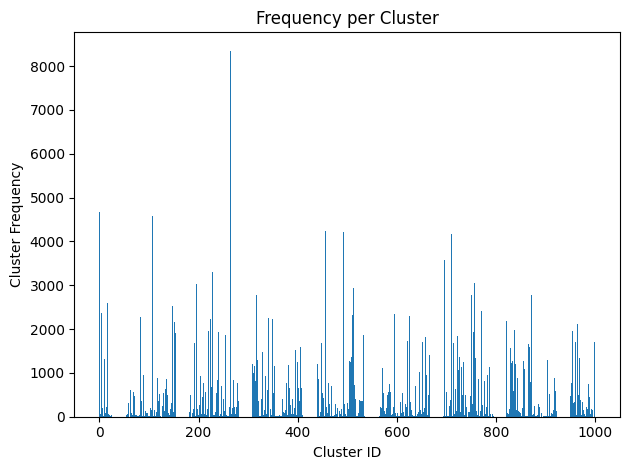

In [90]:
plt.figure()
plt.bar(cluster_ids, df['cluster_freq'].values)
plt.xlabel('Cluster ID')
plt.ylabel('Cluster Frequency')
plt.title('Frequency per Cluster')
plt.tight_layout()
plt.show()

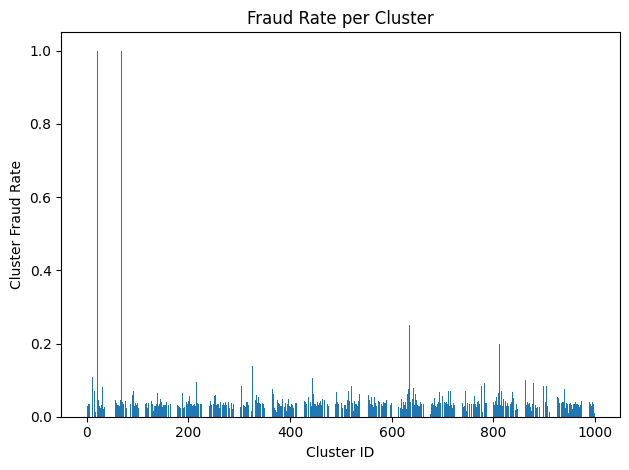

In [45]:
plt.figure()
plt.bar(df['cluster_id'], df['cluster_fraud_rate'].values)
plt.xlabel('Cluster ID')
plt.ylabel('Cluster Fraud Rate')
plt.title('Fraud Rate per Cluster')
plt.tight_layout()
plt.show()

In [48]:
# Statistical threshold
mean_rate = cluster_fraud_rate.mean()
std_rate  = cluster_fraud_rate.std()
stat_thresh = mean_rate + std_rate

high_stat = cluster_fraud_rate[cluster_fraud_rate > stat_thresh]
print(f"\nNumber of clusters with fraud rate > mean + std = {len(high_stat)})")

low_stat = cluster_fraud_rate[cluster_fraud_rate > mean_rate]
print(f"\nNumber of clusters with fraud rate > mean = {len(low_stat)})")

zero_stat = cluster_fraud_rate[cluster_fraud_rate == 0]
print(f"\nNumber of clusters with fraud rate = 0 = {len(zero_stat)})\n")

print(high_stat.sort_values(ascending=False))


Number of clusters with fraud rate > mean + std = 32)

Number of clusters with fraud rate > mean = 424)

Number of clusters with fraud rate = 0 = 184)

cluster_id
21     1.000000
68     1.000000
635    0.250000
812    0.200000
766    0.200000
549    0.200000
482    0.200000
624    0.166667
490    0.166667
927    0.142857
326    0.137931
20     0.129032
172    0.125000
949    0.117647
762    0.116279
142    0.111111
11     0.107143
444    0.105263
87     0.105263
260    0.100000
654    0.100000
707    0.100000
863    0.100000
691    0.095238
216    0.093750
363    0.090909
183    0.090909
783    0.090909
99     0.090909
879    0.090909
518    0.090909
719    0.085714
Name: cluster_fraud_rate, dtype: float64


In [49]:
# Numeric‐feature aggregations (mean & std)

numeric_feats = ['TransactionAmt',\
                  'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',\
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10','C11', 'C12', 'C13', 'C14']  

for feat in numeric_feats:
    grp = df.groupby('cluster_id')[feat]
    df[f'{feat}_cluster_mean'] = df['cluster_id'].map(grp.mean())
    df[f'{feat}_cluster_std']  = df['cluster_id'].map(grp.std())

In [51]:
numeric_feats = ['TransactionAmt',\
                  'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',\
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10','C11', 'C12', 'C13', 'C14']  

for feat in numeric_feats:
    df.drop(columns=[f'{feat}_cluster_std'], inplace=True)

In [52]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? False


In [53]:
# List of categorical columns
df_cat['cluster_id'] = cluster_ids

cat_cols = ['card4','card6','P_emaildomain']

for col in cat_cols:
    # find the most frequent category in each cluster
    mode_series = (
        df_cat.groupby('cluster_id')[col]
          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
          .rename(f'{col}_cluster_mode')
    )
    # map it back to every row
    df[f'{col}_cluster_mode'] = df['cluster_id'].map(mode_series)

In [55]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? True


In [56]:
for col in cat_cols:
    df.drop(columns=[f'{col}_cluster_mode'], inplace=True)

In [57]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? False


In [59]:
# V‑column missingness by cluster
missing_df['cluster_id'] = cluster_ids

In [60]:
# inject the cluster IDs into missing_df (align by index)
missing_df = missing_df.copy()               # avoid SettingWithCopy
missing_df['cluster_id'] = df['cluster_id']  # now it has that column

# groupby cluster_id and take the mean of the 0/1 flags
cluster_miss = missing_df.groupby('cluster_id').mean()
# cluster_miss is a DataFrame:
#   index = cluster_id
#   columns = your V-columns (e.g. 'V138', 'V139', …)
#   values = fraction of missing rows in that cluster

# map each cluster’s missing‐rate back to the main df
for v in cols_10:
    df[f'{v}_cluster_missrate'] = df['cluster_id'].map(cluster_miss[v])


/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_76826/3097977283.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{v}_cluster_missrate'] = df['cluster_id'].map(cluster_miss[v])
/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_76826/3097977283.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{v}_cluster_missrate'] = df['cluster_id'].map(cluster_miss[v])
/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_76826/3097977283.py:14: PerformanceWarning: DataFrame is highly fragmented.  This

In [61]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? False


In [62]:
# drop the cluster_id and cluster_fraud_rate
df.drop(columns=['cluster_id', 'cluster_fraud_rate'], inplace=True)

In [63]:
has_any_nan = df.isna().any().any()
print("Any NaNs in df?", has_any_nan)

Any NaNs in df? False


In [59]:
# cols_to_drop = the original V‑columns you flagged (i.e. missing_df’s columns)
cols_to_drop = missing_df.columns.tolist()

# drop them from df in place
df.drop(columns=cols_to_drop, inplace=True)

In [60]:
# Also drop all the categorical group aggregated features for now
cols_to_drop = ['card4_cluster_mode'] + ['card6_cluster_mode'] + ['P_emaildomain_cluster_mode']
# drop them from df in place
df.drop(columns=cols_to_drop, inplace=True)


In [84]:
# do median imputation again in case of any NaNs introduced by the previous steps
from sklearn.impute import SimpleImputer

# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [64]:
# Create new training and CV sets
# all non‐fraud examples
df_norm = df[df.isFraud == 0].copy()
# all fraud examples
df_fraud = df[df.isFraud == 1].copy()

# hold out 20% of normals for CV
norm_train, norm_cv = train_test_split(
    df_norm, test_size=0.2, random_state=42
)

# CV set = held‐out normals + all frauds
df_cv = pd.concat([norm_cv, df_fraud], axis=0)
y_cv  = df_cv["isFraud"].values

# drop labels for modeling
X_train = norm_train.drop("isFraud", axis=1).values
X_cv    = df_cv.drop("isFraud", axis=1).values

print("→ Training on normals only:", X_train.shape)
print("→ CV set (normals+fraud):", X_cv.shape)

→ Training on normals only: (455901, 612)
→ CV set (normals+fraud): (134639, 612)


In [65]:
# Optional standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv    = scaler.transform(X_cv)  

In [66]:
# Convert to PyTorch tensors
x_train = torch.FloatTensor(X_train)
x_valid = torch.FloatTensor(X_cv)
y_valid = torch.FloatTensor(y_cv)

In [67]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [68]:
# Build Pytorch loaders
BATCH_SIZE = 64

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(valid_set,   batch_size=BATCH_SIZE, shuffle=False)

In [69]:
# Our autoencoder consists of the following layers:
# A first input layer with ReLu activation (input_size, intermediate_size_1)
# A second layer with ReLu activation (intermediate_size_1, intermediate_size_2)
# A third layer with ReLu activation (intermediate_size_2, code_size)
# A fourth layer with ReLu activation (code_size, intermediate_size_2)
# A fifth layer with ReLu activation (intermediate_size_2, intermediate_size_1)
# An output layer with linear activation (intermediate_size_1, input_size)

class DeepAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size_1, intermediate_size_2, code_size):
            super(DeepAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size_1 = intermediate_size_1
            self.intermediate_size_2 = intermediate_size_2
            self.code_size = code_size

            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size_1)
            self.fc2 = torch.nn.Linear(self.intermediate_size_1, self.intermediate_size_2)
            self.fc3 = torch.nn.Linear(self.intermediate_size_2, self.code_size)
            
            #decoder 
            self.fc4 = torch.nn.Linear(self.code_size, self.intermediate_size_2)            
            self.fc5 = torch.nn.Linear(self.intermediate_size_2, self.intermediate_size_1)
            self.fc6 = torch.nn.Linear(self.intermediate_size_1, self.input_size)
            
            
        def forward(self, x):
            
            hidden1 = self.fc1(x)
            hidden1 = self.relu(hidden1)

            hidden2 = self.fc2(hidden1)
            hidden2 = self.relu(hidden2)

            code = self.fc3(hidden2)
            code = self.relu(code)

            hidden2 = self.fc4(code)
            hidden2 = self.relu(hidden2)

            hidden1 = self.fc5(hidden2)
            hidden1 = self.relu(hidden1)

            output = self.fc6(hidden1)
            #linear activation in final layer

            return output

In [70]:
criterion = torch.nn.MSELoss()

In [71]:
seed_everything(SEED)
model = DeepAutoencoder(x_train.shape[1], 256, 64, 16)
losses = per_sample_mse(model, val_loader)

In [72]:
print(losses[0:5])
print(np.mean(losses))

[np.float32(0.49511), np.float32(2.386697), np.float32(0.0925188), np.float32(0.20682506), np.float32(2.0352104)]
1.584712


In [73]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

In [74]:
class EarlyStopping:
    
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience 

In [75]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=3,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_batch)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_batch)
            # Backward pass
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [77]:
model,training_execution_time,train_losses,valid_losses = training_loop(model,train_loader,val_loader,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.4077200873732433
valid loss: 0.6497667630560724
New best score: 0.6497667630560724

Epoch 1: train loss: 0.2962359102826685
valid loss: 0.6047489227011743
New best score: 0.6047489227011743

Epoch 2: train loss: 0.25892014824197007
valid loss: 0.49456777404852126
New best score: 0.49456777404852126

Epoch 3: train loss: 0.24067916240331866
valid loss: 0.4664794941762101
New best score: 0.4664794941762101

Epoch 4: train loss: 0.23212728586104364
valid loss: 0.4704600082844949
1  iterations since best score.

Epoch 5: train loss: 0.221597619387146
valid loss: 0.4343813599048345
New best score: 0.4343813599048345

Epoch 6: train loss: 0.21340925894167267
valid loss: 0.42612696840948366
New best score: 0.42612696840948366

Epoch 7: train loss: 0.208158230257379
valid loss: 0.41256273142681826
New best score: 0.41256273142681826

Epoch 8: train loss: 0.20157338749431178
valid loss: 0.40847628342674713
New best score: 0.40847628342674713

Epoch 9: train loss: 0.19603

In [78]:
losses = per_sample_mse(model, val_loader)
print(losses[0:5])
print(np.mean(losses))

[np.float32(0.035467338), np.float32(0.35462266), np.float32(0.017254699), np.float32(0.03370414), np.float32(0.21462257)]
0.3046958


In [79]:
genuine_losses = np.array(losses)[y_valid.numpy() == 0]
fraud_losses = np.array(losses)[y_valid.numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 1.230195
Average genuine reconstruction error: 0.13690972


In [80]:
# compute AUC-ROC and Average Precision on the validation set by considering the reconstruction errors as predicted fraud scores

AUC_ROC = roc_auc_score(y_cv, losses)
AP = average_precision_score(y_cv, losses)
    
performances = pd.DataFrame([[AUC_ROC, AP]], columns=['AUC ROC','Average precision'])

In [88]:
from sklearn.metrics import recall_score

thr      = np.percentile(losses, 95)      # e.g. top 5% as “fraud”
y_pred   = (losses >= thr).astype(int)
recall   = recall_score(y_cv, y_pred)    # binary‐class recall
print(f"Recall at threshold {thr:.4f} = {recall:.4f}")


Recall at threshold 0.7676 = 0.2263


In [81]:
performances

,AUC ROC,Average precision
0,0.760555,0.476097
